In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def f(x):
    return 3*x**2 - 4*x + 5

In [23]:
f(3.0)

20.0

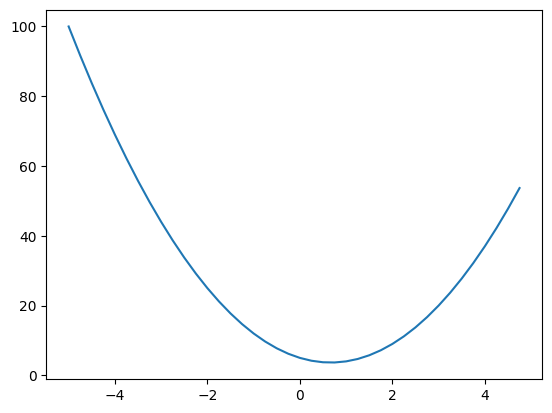

In [24]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [25]:
h = 0.00001
x = 3.0
(f(x + h) - f(x)) / h

14.00003000000538

In [26]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [27]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+') 
        def _backward():
            ''' 
            (d out / d self.data) = 1.0 
            d ??? / d out = out.grad
            '''
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),'*') 

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def __rmul__(self,other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = None # ???
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            '''
            v : root node
            starting at root node, 
            go through all of its children(= leaf node), 
            lay them out from left to right.

            Recursively traverses all child nodes before adding the current node to the topo list.
            '''
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [29]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


L = d * f  
we want to derivative : dL/dd ? 
-> It will be 'f'

what about dL / dc?  
WANT:  
dL / dc = (dL / dd) * (dd / dc)  

KNOW:  
dL / dd  
dd / dc  

dL / de = -2.0

e = a * b
de / da? b

dL / da = (dL / de) * (de / da)
dL / db = (dL / de) * (de / db)

### manual backpropagation example : 2: a neuron

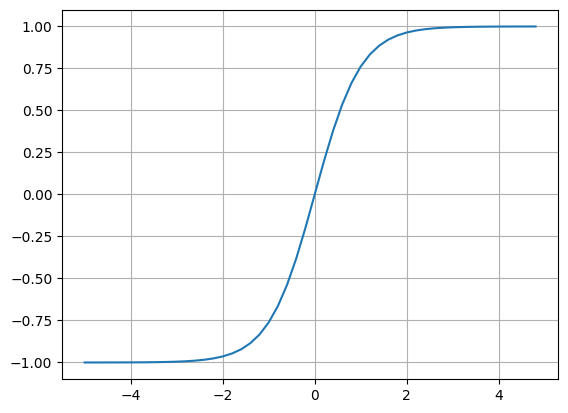

In [30]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [31]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

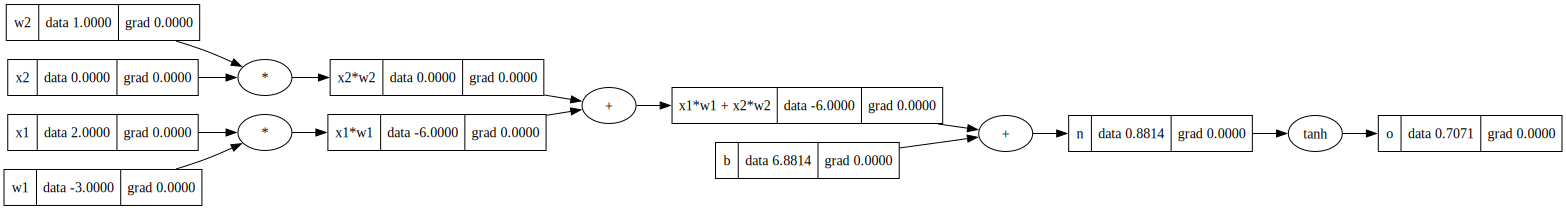

In [32]:
draw_dot(o)

In [33]:
o.grad = 1.0
# n.grad = do/dn = 1 - o ** 2 = d tanh n / dn
n.grad = 0.5

# n = x1w1x2w2 + b, 모두 편미분 결과는 1 x1w1x2w2 / dx1w1
# do/d x1w1x2w2 역시 chain rule,
# do/dn * dn/dx1w1x2w2 = 0.5 * 1
# 마찬가지로 do / db = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

# x1w1x2w2 = x1w1 + x2w2
# do/ dx1w1 = do / d x1w1x2w2 * d x1w1x2w2 / dx1w1
# = 0.5 * 1
x1w1.grad = 0.5
x2w2.grad = 0.5

# do/dx1 = do / dx1w1 * dx1w1 / dx1
# = x1w1.grad * w1
x1.grad = 0.5 * -3.0
# do/dw1 = do / dx1w1 * dx1w1 / dw1
# = x1w1.grad * x1
w1.grad = 0.5 * 2.0

# same here
x2.grad = 0.5 * 1.0
w2.grad = 0.5 * 0.0
# w2.grad가 0인 것에 대한 직관적으로 생각해보자.
# x2가 0이므로, w2를 어떻게 변화시키던, 최종 결과값에 미치는 영향을 없을 것이다.
# 따라서 grad가 0인 것이 납득이 된다.


### implementing the backward function for each operation

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

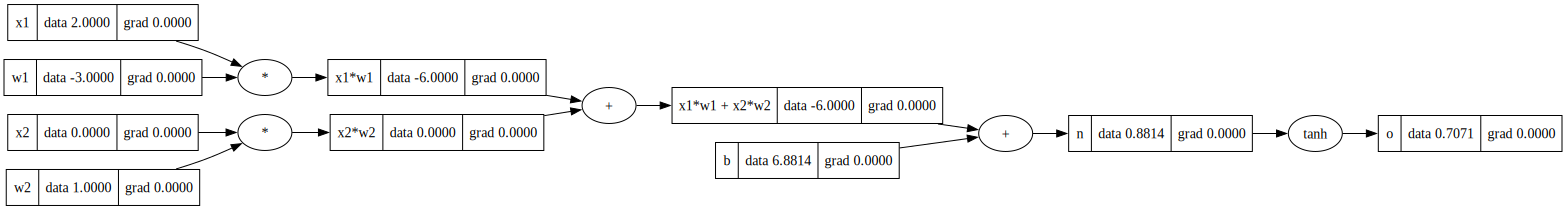

In [35]:
draw_dot(o)

In [36]:
o.grad = 1.0

In [37]:
o._backward()

In [38]:
n._backward()

In [39]:
b._backward()
x1w1x2w2._backward()

In [40]:
x1w1._backward()
x2w2._backward()

### build topological graph

In [41]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    '''
    v : root node
    starting at root node, 
    go through all of its children(= leaf node), 
    lay them out from left to right.

    Recursively traverses all child nodes before adding the current node to the topo list.
    '''
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

### removing bug

연산 과정에서, 동일한 변수를 곱하거나 더한다면, grad가 덮어씌워진다.  
따라서, 누적 연산 형태로 바꾼다.

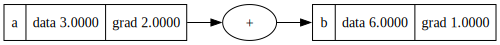

In [42]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

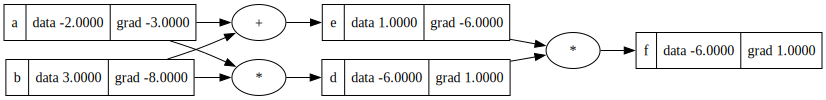

In [60]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'   
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

In [65]:
2 * a

Value(data=-4.0)